<a href="https://colab.research.google.com/github/np1011/StaffingandGraduationRatesPhiladelphiaSchools/blob/main/DSCI_632_Final_FirstDraft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSCI 632 Final

Your final is to use the dataset of your choice and the techniques in this class to do the following:

1. Define and describe the dataset (10 points)
1. Clean the data (10 points)
1. Transform the clean data (10 points)
1. Show your analysis of the data (10 points)

## Ground Rules

1. Explain everything you're doing with pyspark in the code cells using [markdown](https://www.markdownguide.org/cheat-sheet) in text cells. Help the reader understand why you're doing each step so they can re-create it. Remember, this is an assignment to show how you analyze data to a potential employer. Don't use code comments to explain things.
1. All of the sections are heading 1 in markdown, so use heading 2 to write your explainations, and heading 3 for any sub-headers. Check in your table of contents view in colab to make sure each point is listed before you turn this in.
1. Don't hesisate to use multiple code/text cells in each section, as long as they're all labeled and described.
1. Assume that the reader doesn't have access to the dataset on your local machine. Provide a link to the dataset you're using, or if able, include code to copy it from a public source. Don't rely on uploading from your local machine. (Importing from Google Drive is ok, as long as you provide the link to the data)
1. If using GCP services, include screenshots from your console if there's a step that you aren't able to re-produce in code. Using the SDK is always preferred, but you won't lose points for using screenshots and explaining them.
1. Import the data ONCE, then transform it to fit your analysis.
1. Don't overwrite data, make new columns for new transformations. You can always drop columns later, but you can't get overwritten values back.
1. Feel free to work with classmates, but all work submitted must be your own.
1. Make sure to run disconnect the runtime and re-run the notebook at least once before turning in. If you are getting certain Java runtime errors, this might also help.

## Extra Credit Opportunities!

- If you provide a link to this notebook on your public GitHub page instead of turning it in as an attachment, you will get 2 points extra credit.
- Extra credit will be given for using the [Google Cloud SDK](https://cloud.google.com/sdk/) to create/use/destroy any cloud resources, up to 2 points per section, 8 points total.
 - Don't be afraid to look at the GCP example colab notebooks from the class notes, the GCP documentation, or GitHub for examples.
- If this notebook is self-contained, you will get 5 points extra credit. (Requirements below)
 - The data is imported without relying on Google Drive, as the paths to data in Google Drive are user-specific. Downloads from public storage buckets/services are fine. (1 point)
 - It be run from start to finish without making any changes to paths, code, or variable names. (1 point)
 - All calls to external services, including GCP, are done programatically, no screenshots explaining how it worked in a browser console. (Using an API or SDK, 2 points)
 - All cloud resources are destroyed at the end of the notebook in a seperate section (Also via API or SDK, 1 point)

---

## Section 1
### Define and describe the dataset

10 points

Import the dataset, and describe why you'll be analyzing in it. You can summarize a few columns, show a more information on the relavent features, or but help the reader understand what the dataset is, what is in it, and why you picked it.

Some questions that it might help you to answer:
1. Why are you choosing this dataset?
1. What variables will you use?
1. What analysis(es) will you run?
1. Do you have any hypotheses? What are they?

### This section should include one or more of the following:
- A histogram of several features relavent to your analysis
- The schema of the dataset, with the datatypes assigned correctly
- A text cell with explainations of the relavent features in [markdown](https://www.markdownguide.org/cheat-sheet)
- Use Spark SQL or built-in methods to show a range of values
- Most common words/n-grams found

## Section 1, Part 0 - Overview

1. Why are you choosing this dataset?

I selected this dataset in large part because I happen to know a lot of public school teachers who, shortly before this assignment, were discussing the challenges of working in schools with indadequate  staff (for example, not enough social workers). I wanted to investigate whether I could find data-based evidence on the relationship between school performance and staffing.

The Philadelphia School District (PSD) provides a wide array of metrics for looking into this question. I chose to look at Graduation Rates as the metric of success, since High School Graduation status is an important metric of future earning potential.

2. What variables will you use?

I plan to use some calculated variables - total staff to student ratio, for example, as well as the data points provided by the PSD. They have metrics such as - enrollment type (cityside vs neighborhood), staff category, whether or not students are considered disadvantaged. These can help illimunate some of the statistics, because while a school may have a lower overall graduation rate they may be relatively higher performing for disadvanted students, for example.

3. What analysis(es) will you run?

The primary analysis I would like to run is a Spearman correlation analysis. This can answer my initial question of whether more staff correlates with higher graduation rates. I am also hoping it reveals other interesting patterns that I can dive into, such as relationships between employment data and student groups (such as IEP status)


4. Do you have any hypotheses? What are they?

I believe there will be a relationship between staffing levels and graduation rates. I am curious, however, since I am looking at a single district with a shared budget, how that will play out. Will staff resources  be higher at low performing schools because of high-need student populations? Students with IEPs may call for additional staff, for example, but could potentially hamper student graduation rates because they indicate learning differences. Or do higher performing schools attract resources, with more staff supporting the success of schools with better graduation rates?


## Section 1, Part 1 : Environment Set Up

In Section: Part 1 I will setup the PySpark environment required to run the analysis.

In [169]:
# Install Spark 3.2.4
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-eu.apache.org/dist/spark/spark-3.2.4/spark-3.2.4-bin-hadoop2.7.tgz
!tar xf spark-3.2.4-bin-hadoop2.7.tgz

In [170]:
# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.4-bin-hadoop2.7"

In [171]:
!python -m pip install --upgrade pyspark==2.4.0
!python -m pip install -q findspark

In [172]:
import findspark
findspark.init()

In [173]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [174]:
from pyspark.sql import SparkSession

In [175]:
APP_NAME = "PHLSchools"

In [176]:
spark = SparkSession.builder.appName(APP_NAME).getOrCreate()

In [177]:
spark

In [178]:
from pyspark.sql.functions import col
from pyspark.sql.functions import countDistinct, split, monotonically_increasing_id, udf, count, collect_list, avg

##Section 1, Part 2 - Import data from GitHub Repository (School List, Graduation Rate & Employment Data)

The required data comes from 3 different locations on the  [Philadelphia School District (PSD) website](https://www.philasd.org/performance/programsservices/open-data/). In Section 1, I will load each of the 3 data sources into dataframes with the correct schemas, check that they've loaded properly and review important variables from each.

In [179]:
#Load Data from Public GitHub Repository
!git clone https://github.com/np1011/StaffingandGraduationRatesPhiladelphiaSchools

!ls

fatal: destination path 'StaffingandGraduationRatesPhiladelphiaSchools' already exists and is not an empty directory.
gdrive			       spark-3.2.4-bin-hadoop2.7.tgz.1
sample_data		       spark-3.2.4-bin-hadoop2.7.tgz.2
spark-3.2.4-bin-hadoop2.7      StaffingandGraduationRatesPhiladelphiaSchools
spark-3.2.4-bin-hadoop2.7.tgz


I. Load School List Data

**The important variables here will be**:
* School Name
* School Level (Elementary, Middle or High School)
* Admission Type (Whether a school population is based on zip code or a filtered admissions process)


First file is the School List for 2022-2023. I am only going to examine currently operating schools, so one year of current data is the appropriate reference point. This file will give a reference point for current schools and also provide the IDs used across datasets so they can be joined cleanly.

Source: https://www.philasd.org/performance/programsservices/open-data/school-information/#school_lists

In [180]:
#Read in data file, infer schema and display first 5 rows
schoolList0 = spark.read.options(header = 'True', inferSchema='True',delimiter=',') \
  .csv("/content/StaffingandGraduationRatesPhiladelphiaSchools/2022_2023_Master_School_List.csv")

schoolList0.show(5)

#Check Schema
schoolList0.printSchema()

+-------+--------+------------+---------+---------+-------------+--------------------+--------------------+---------------------------+-----------------+-----------+------------+--------------+-------------------------+-------------------+----------+-----------+----------+-----------------------+-------------------------+------------------------+--------------------+-----------------------+-----------------------+----------+-------------------+----------------------------------+---------------------+--------------------+------------------+-----------------+------------+-----+--------+------------+------------+--------------------+--------------------+----------------+------------------------+--------------------+--------------------+-------------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+
|PA Code|NSC Code|   NCES Code| AUN Code|ULCS Code|SRC School ID|  School Name (ULCS)|    Publication Name|Publication Name

### Collect Important Data Points from the School List

*   There are 56 Unique High Schools in the PSD
*   The below cell also displays school name with Admission Type, and count of High Schools by Admission Type since I believe Admission Type will be an important variable in graduation rate. Selecting the pool of students will likely improve graduation rates.



In [181]:
#Get list of All PSD High Schools
schoolList0.select('Publication Name', 'Admission Type', 'ULCS Code').where(col('School Level') == 'High').show(60,truncate = False)
schoolList0.select('Publication Name').where(col('School Level') == 'High').count()
admissiontypecount = schoolList0.where(col('School Level') == 'High').groupBy('Admission Type').count()
admissiontypecount.show(truncate = False)

schoolListData = schoolList0.select('Publication Name', 'Admission Type', 'ULCS Code').where(col('School Level') == 'High')

+--------------------------------------------------------------------------+----------------------+---------+
|Publication Name                                                          |Admission Type        |ULCS Code|
+--------------------------------------------------------------------------+----------------------+---------+
|John Bartram High School                                                  |Neighborhood          |1010     |
|West Philadelphia High School                                             |Neighborhood          |1020     |
|High School of the Future                                                 |Citywide              |1030     |
|Paul Robeson High School for Human Services                               |Citywide              |1050     |
|William L. Sayre High School                                              |Neighborhood          |1100     |
|Motivation High School                                                    |Special Admit         |1190     |
|South Phi

### II. Load Graduation Rate Data

The important variables here will be:
* cohort - year the class started 9th grade
* schoolname - Name of the school
* schoolid_ulcs - ID to use to normalize data with School List
* rate_type - 4, 5 or 6 year graduation rate for the cohort
* demon - total number of students in the cohort
* score - ratio of total graduates to denom (graduation rate)
* group & subgroup - define aspects of a cohort (i.e. English Language Learner (ELL), Economically Disadvantaged)

Next I will upload a file of graduation rates. It goes from 2013-2022. Employee data is available starting in 2014, so this date range matches up well and I do not need to go back further.

I am going to do a small amount of clean up here so I can do a box plot at this step to get a picture of the data.

Source: https://www.philasd.org/performance/programsservices/open-data/school-performance/#school_graduation_rates

In [182]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, FloatType

In [183]:
#Read in data file, infer schema and display first 5 rows
customSchema = StructType([
    StructField('cohort', StringType(), True),
    StructField('schoolid_ulcs', IntegerType(), True),
    StructField('schoolname', StringType(), True),
    StructField('sector', StringType(), True),
    StructField('rate_type', StringType(), True),
    StructField('group', StringType(), True),
    StructField('subgroup', StringType(), True),
    StructField('demon', IntegerType(), True),
    StructField('num', IntegerType(), True),
    StructField('score', FloatType(), True),
])

gradRate0 = spark.read.format("csv").option("header", "true").option("delimiter", ",").schema(customSchema).load("/content/StaffingandGraduationRatesPhiladelphiaSchools/Graduation_Rates_2023-02-15.csv")

gradRate0.show(truncate = False)

#Check Schema
gradRate0.printSchema()

gradRate0.count()

+---------+-------------+------------------------+--------+----------------------+--------------------------+------------------------------+-----+----+-----+
|cohort   |schoolid_ulcs|schoolname              |sector  |rate_type             |group                     |subgroup                      |demon|num |score|
+---------+-------------+------------------------+--------+----------------------+--------------------------+------------------------------+-----+----+-----+
|2010-2011|1010         |John Bartram High School|District|4-Year Graduation Rate|All Students              |All Students                  |281  |203 |72.24|
|2010-2011|1010         |John Bartram High School|District|4-Year Graduation Rate|Economically Disadvantaged|Economically Disadvantaged    |211  |153 |72.51|
|2010-2011|1010         |John Bartram High School|District|4-Year Graduation Rate|Economically Disadvantaged|Not Economically Disadvantaged|70   |50  |71.43|
|2010-2011|1010         |John Bartram High School|Di

26163

There are null values in the graduation rate data (score). Since null values cannot be used for analysis (if there is no graduation rate data there is nothing to compare). I am proactivey removing all the nulls at this step. I am doing this in Section 1 instead of Section 2 so I can create a clean Box Plot to view.

Before Dropping Nulls there were 26,163 rows. After Dropping Nulls there are 15,362

In [184]:
#Comparing the Nulls to the School List, the null values are schools that aren't active in the current school list. Drop them
from pyspark.sql.functions import when, count, col, isnull

#Check where nulls are
gradRate0.select([count(when(isnull(c), c)).alias(c) for c in gradRate0.columns]).show()

cleanGradRate = gradRate0.na.drop()
cleanGradRate.count()

+------+-------------+----------+------+---------+-----+--------+-----+-----+-----+
|cohort|schoolid_ulcs|schoolname|sector|rate_type|group|subgroup|demon|  num|score|
+------+-------------+----------+------+---------+-----+--------+-----+-----+-----+
|     0|            0|         0|     0|        0|    0|       0|    0|10801|10801|
+------+-------------+----------+------+---------+-----+--------+-----+-----+-----+



15362

### Find Outliers in Graduation Rates to Check Data Quality

There are some outliers with exceedingly low graduation rates however, reviewing them, I can see that when the dataframes are combined in Section 2 these should be remedied. These schools are not included in the School List data, which is likely a reason for their outlier status (data may be incomplete or schools are no longer operating).

Additionally it is important to note that the 'cohort' variable referes to the year a student started 9th grade, not their graduation year.

In [185]:
#Select all student graduation rates
allStudentGrad = cleanGradRate.filter((col('group') == 'All Students') & (col('cohort') == '2018-2019') & (col('rate_type') == '4-Year Graduation Rate')).select(col('score'), col('schoolname'))

#Show Ordered Graduation Rates
allStudentGradDisplay = allStudentGrad.orderBy('score').show(100, truncate = False)


+-----+-------------------------------------------------------+
|score|schoolname                                             |
+-----+-------------------------------------------------------+
|2.44 |Phila. Juv. Justice Services Ctr.                      |
|3.7  |Philadelphia Learning Academy North                    |
|3.85 |YESPhilly                                              |
|8.97 |Excel Academy South                                    |
|9.09 |One Bright Ray - Elmwood Campus                        |
|10.68|One Bright Ray - Fairhill Campus                       |
|10.89|One Bright Ray - Simpson Campus                        |
|11.32|One Bright Ray Mansion                                 |
|11.9 |Ben Franklin High School EOP                           |
|15.94|El Centro de Estudiantes (Big Picture)                 |
|15.94|Excel Academy North                                    |
|18.18|OIC CADI                                               |
|18.52|Northeast High School EOP        

### Visualize Graduation Rate Distribution with Box Plot

Use the allStudentGrad dataframe, that selects the 4-year graduation rate for the most recent available cohort (2018-2019). Convert the dataframe to pandas, then display a box plot to visualize the mean and outliers.

You can see on this plot that on average, PSD schools are graduated less than 80% of this cohort of students in 4-years.

<Axes: >

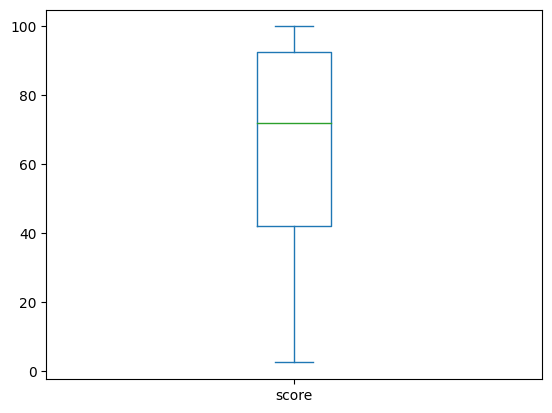

In [186]:
#Display Box Plot of Graduation Rates
pandaGrad = allStudentGrad.toPandas()

pandaGrad['score'].plot.box()

### III. Load Employee Data

Important Variables:
* PAY_RATE_TYPE: Hourly or Salaried
* PAY_RATE
* TITLE_DESCRIPTION : Job Title
* HOME_ORGANIZATION : School ID that is normalized across dataframes (School names are formatted differently than in graduation rate data, so cannot be used to compare)
* RUN_DATE: Date data was pulled, allows for matching data to school year

The final piece of data is employee information. This is not as neat of a dataset because data is provided in CSV's year by year. I will upload the files, then combine them into a single dataframe.

This data had to be cleaned up before I could even load it. The files were not named consistently (different capitalization and underscore usage) and some zip files contained Read Me while others did not. The data is also provided multiple times per year, creating duplicates, and not always for the same month. To avoid inconsistency we will look at employment in July of each year - a snapshot of who was employed just before the school year started. 2021-2022 also only has July data so this allows for consistency.

In Section 2, this data will be consolidated into statistics (i.e. average employee pay, average count of employee per student)

In [187]:
#https://stackoverflow.com/questions/60261615/how-can-i-merge-these-many-csv-files-around-130-000-using-pyspark-into-one-lar
rdd = spark.sparkContext.emptyRDD()

schema = StructType([
  StructField('LAST_NAME', StringType(), True),
  StructField('FIRST_NAME', StringType(), True),
  StructField('PAY_RATE_TYPE', StringType(), True),
  StructField('PAY_RATE', IntegerType(), True),
  StructField('TITLE_DESCRIPTION', StringType(), True),
  StructField('HOME_ORGANIZATION', StringType(), True),
  StructField('HOME_ORGANIZATION_DESCRIPTION', StringType(), True),
  StructField('ORGANIZATION_LEVEL', StringType(), True),
  StructField('TYPE_OF_REPRESENTATION', StringType(), True),
  StructField('GENDER', StringType(), True),
  StructField('RUN_DATE', StringType(), True),
  ])
result = spark.createDataFrame(rdd, schema)

for year in range(2014,2022):
    year_str = str(year)
    year_next = str(year+1)

    df = spark.read.format("csv").option("header", "true").option("delimiter", ",").schema(schema).load("/content/StaffingandGraduationRatesPhiladelphiaSchools/Employee_Data_All_Years_2023/Employee_Data_" + year_str + "_" + year_next + "/employee_information_July"+year_str+".csv")

    if result:
        result = result.union(df)
    else:
        result = df
result.show(10)
result.count()
result.printSchema()

+-----------+----------+-------------+--------+--------------------+-----------------+-----------------------------+--------------------+----------------------+------+---------+
|  LAST_NAME|FIRST_NAME|PAY_RATE_TYPE|PAY_RATE|   TITLE_DESCRIPTION|HOME_ORGANIZATION|HOME_ORGANIZATION_DESCRIPTION|  ORGANIZATION_LEVEL|TYPE_OF_REPRESENTATION|GENDER| RUN_DATE|
+-----------+----------+-------------+--------+--------------------+-----------------+-----------------------------+--------------------+----------------------+------+---------+
|     ANGENY|      JOHN|     SALARIED|   83382|   TEACHER,FULL TIME|             8240|         DISSTON, HAMILTON...|   ELEMENTARY SCHOOL|           PFT-TEACHER|     M|7/15/2014|
|     ANGERT|     JASON|     SALARIED|   79586|   TEACHER,FULL TIME|             7440|         TAYLOR, BAYARD SC...|   ELEMENTARY SCHOOL|           PFT-TEACHER|     M|7/15/2014|
| ANGIOLILLO|   KAITLIN|       HOURLY|      39|TEACHER-EXTRA CUR...|             9EW0|         PARENT AIDE, SP

### Checking that Employee Data was Loaded Successfully

Below I am reviewing the total run dates to make sure all the employee data files that I intended to upload were in fact included in the upload.

In [188]:
#Checking to make sure all the files were included (they each have a unique run date)
result.select("RUN_DATE").distinct().show()

#Get count of total rows
print('Total Rows of Employee Data')
result.count()

+---------+
| RUN_DATE|
+---------+
|7/15/2014|
| 7/1/2015|
| 7/1/2016|
| 7/1/2017|
| 7/1/2018|
| 7/1/2019|
| 7/1/2020|
| 7/1/2021|
+---------+

Total Rows of Employee Data


150895

### Clean Up by Unmounting Google Drive

In [189]:
drive.flush_and_unmount()

# Section 2: Clean the data

10 points

Not every dataset is going to be ready to use right away. Take steps to fix incorrect inputs, remove null values, and assign datatypes that fit each feature.

### This section should include one or more of the following:
- A count of rows before and after dropping data with null or incorrect values, including an explaination of why removing the rows was necessary in [markdown](https://www.markdownguide.org/cheat-sheet).
- Renaming a column, adding a new one, or casting an existing one as a different datatype.
- Remove punctuation marks, symbols, etc from the data, and convert all upper-case lettering to lower-case.
- Remove or fix rows that have bad values/data.

## Clean Up & Combine School List Data with Graduation Rate Data

In order to include only the currently active PSD high schools, I am going to filter the Graduation Rate Data by the School List data by the ULCS code.

First, normalize the ID column names in gradRate and schoolList to 'ULCS'. Then limit the schoolListData dataframe to High Schools only.

In [190]:
#Normalize the column names
cleanGradRate = cleanGradRate.withColumnRenamed("schoolid_ulcs","ULCS")
schoolListClean = schoolListData.withColumnRenamed("ULCS Code", "ULCS")

#Limit the School List to Only High Schools
highSchoolList = schoolListClean.filter(col("School Level") == "High")

Perform a join on ULCS ID. This will limit the grad rate list to only the currently active high schools.

There were 56 total high schools, but only 46 remain in this join. That is because schools some schools were not included in the graduation data and some schools provided null values and were dropped in Section 1.

The following edits will be made:

* Add columns named Freshman and Senior, based on the cohort column, to indicate the year the cohort started high school and the year they would graduate, if graduating in 4 years. This can be used to compare to employment data by year.

* Filter to 4-Year-Graduation-Rate only so that there is a single metric to look to

In [191]:
#Join School List and Grad Data by ULCS ID
gradFiltered = cleanGradRate.join(highSchoolList, ["ULCS"], "inner")

#Check new unique school count
gradFilteredCount = gradFiltered.select(countDistinct("ULCS"))
gradFilteredCount.show()

#Add Freshman & Senior Columns, Cast as Integers
gradFiltered1 = gradFiltered.withColumn("freshman", split(gradFiltered["cohort"], "-").getItem(0))
gradFiltered1 = gradFiltered1.withColumn("senior",col("freshman") + 4)
gradFiltered1 = gradFiltered1.withColumn("senior",col("senior").cast("Integer"))
gradFiltered1 = gradFiltered1.withColumn("freshman",col("freshman").cast("Integer"))
gradFiltered2 = gradFiltered1.where(col("rate_type") == "4-Year Graduation Rate")
gradFiltered2.show()

+--------------------+
|count(DISTINCT ULCS)|
+--------------------+
|                  46|
+--------------------+

+----+---------+--------------------+--------+--------------------+--------------------+--------------------+-----+---+-----+--------------------+--------------+--------+------+
|ULCS|   cohort|          schoolname|  sector|           rate_type|               group|            subgroup|demon|num|score|    Publication Name|Admission Type|freshman|senior|
+----+---------+--------------------+--------+--------------------+--------------------+--------------------+-----+---+-----+--------------------+--------------+--------+------+
|1010|2010-2011|John Bartram High...|District|4-Year Graduation...|        All Students|        All Students|  281|203|72.24|John Bartram High...|  Neighborhood|    2010|  2014|
|1010|2010-2011|John Bartram High...|District|4-Year Graduation...|Economically Disa...|Economically Disa...|  211|153|72.51|John Bartram High...|  Neighborhood|    2010|  

## Clean up Employment Data

I am going to perform minimal clean up of the employment data in this section, because this data will primarily be transformed in Section 3 into calculated data columns.

* Rename HOME_ORGANIZATION to ULCS, for consistency
* Add a new column "School_Year_Start" based on the Run Date, to indicate the fall of the school year referenced by the employee data.
* Add Employee ID column, so unique employees can be easily counted
* There are a lot of employees who are not tied to a particular school, from bus drivers to school district accountants, as well as people who work at Middle & Elementary Schools. I will remove them, so we can look at only employees assigned to the 46 active schools for which we have graduation data.

All 46 Schools are correcty represented in the Employee Data. The total employee count, filtered for only employees assigned to these schools is 26,819 down from 150,895 in the original dataset (as calculated in Section 1). This is for 9 years of data. So on average there are 2979 employees per year, with 64 employees per school.

In [192]:
#Rename Home_Organization to ULCS
employeeData = result.withColumnRenamed("HOME_ORGANIZATION","ULCS")

#Create School Year Start column
employeeData = employeeData.withColumn("Year", split(employeeData["RUN_DATE"], "/").getItem(2))

#Get List of 46 ULCS Codes that are being examined
ULCSGroup = gradFiltered.select("ULCS").distinct()
ULCSList = ULCSGroup.select("ULCS").rdd.flatMap(lambda x: x).collect()

#Filter Dataframe to include only 46 ULCS Codes
employeeData1 = employeeData.filter(employeeData['ULCS'].isin(ULCSList))

In [193]:
#Check to make sure all schools are included
employeeData1Count = employeeData1.select(countDistinct("ULCS"))
employeeData1Count.show()

#Get Count of Employees for these 46 schools only
print(employeeData1.count())

#Create Employee ID Column
employeeDataID = employeeData1.withColumn("Employee_ID", monotonically_increasing_id())

employeeDataID.show()

+--------------------+
|count(DISTINCT ULCS)|
+--------------------+
|                  46|
+--------------------+

26819
+-----------+----------+-------------+--------+--------------------+----+-----------------------------+--------------------+----------------------+------+---------+----+-----------+
|  LAST_NAME|FIRST_NAME|PAY_RATE_TYPE|PAY_RATE|   TITLE_DESCRIPTION|ULCS|HOME_ORGANIZATION_DESCRIPTION|  ORGANIZATION_LEVEL|TYPE_OF_REPRESENTATION|GENDER| RUN_DATE|Year|Employee_ID|
+-----------+----------+-------------+--------+--------------------+----+-----------------------------+--------------------+----------------------+------+---------+----+-----------+
|ANKIELEWICZ|     HELEN|     SALARIED|   48110|FOOD SVCS MANAGER II|5150|         BODINE, WILLIAM W...|         HIGH SCHOOL|           PFT-F/S MGR|     F|7/15/2014|2014|          0|
|     ANSLEY|     MABEL|     SALARIED|   11423| FOOD SVCS ASSISTANT|6030|         ROXBOROUGH HIGH S...|         HIGH SCHOOL|             LOCAL 634|   

# Section 3: Transform the clean data

10 points

Once you have clean data, start to prepare it to fit your analysis tools. This might mean using custom code to normalize certain values, joining supplemental datasets, and/or preparing it for machine learning.

### This section should include one or more of the following:
- Write a UDF to perform a function, then use it to add a new column to your data. Explain why in [markdown](https://www.markdownguide.org/cheat-sheet)
- Join an outside data source. (It can be one you've prepared alongside the primary source you're using, as long as you link it)
- Split the data into train/test sets
- Create vectors for relavent features
- One-hot encode catagorical variables

### Calculate Data from Employee Data & Add to Main DataFrame
* Employees per school per school year start
* Teacher, Full-Time per school per year start
* Non-teachers per school per year start
* Average salary (hourly & salaried) per school per school year start

A major consideration here is, how to match the years? Students are in high school for 4 years and employment changes each year. I'm deciding here to match their freshman year to the employment year...looking at the state of the school when they started it...rather when their graduation status is likely already determined senior year.

It is also necessary to estimate school size to get per student counts. That needs to be taken from All Students. I will multiple all students * 4 (4 classes in a high school) to estimate total school population.

In [194]:
#Add Column for Total School Size
totalStudents = gradFiltered2.filter((col("subgroup") == "All Students"))
totalStudents = totalStudents.withColumn("SchoolPop",((col("demon")*4)))

studentPop = totalStudents.select((col("ULCS")),(col("SchoolPop")), col("freshman"))

gradFiltered3 = gradFiltered2.join(studentPop, ["ULCS", "freshman"], "inner")
gradFiltered3.show()

+----+--------+---------+--------------------+--------+--------------------+--------------------+--------------------+-----+---+-----+--------------------+--------------+------+---------+
|ULCS|freshman|   cohort|          schoolname|  sector|           rate_type|               group|            subgroup|demon|num|score|    Publication Name|Admission Type|senior|SchoolPop|
+----+--------+---------+--------------------+--------+--------------------+--------------------+--------------------+-----+---+-----+--------------------+--------------+------+---------+
|7010|    2013|2013-2014|Frankford High Sc...|District|4-Year Graduation...|        All Students|        All Students|  362|210|58.01|Frankford High Sc...|  Neighborhood|  2017|     1448|
|7010|    2013|2013-2014|Frankford High Sc...|District|4-Year Graduation...|Economically Disa...|Economically Disa...|  289|170|58.82|Frankford High Sc...|  Neighborhood|  2017|     1448|
|7010|    2013|2013-2014|Frankford High Sc...|District|4-Yea

#### Calculate Total Employees by Year by School

Calculating count of employees by year, by school ID then joining "School Year Start" and the resulting "Employee_Count" column to the main grad rate dataframe

In [195]:
#Calculate employee count by year
employeeYear = employeeDataID.groupBy('Year', 'ULCS').agg(count('Employee_ID').alias('Employee_Count'))
employeeYear.show()

+----+----+--------------+
|Year|ULCS|Employee_Count|
+----+----+--------------+
|2014|2160|            70|
|2014|4140|            58|
|2014|6540|            31|
|2014|6050|            64|
|2014|4060|            62|
|2014|2000|           130|
|2014|5520|            50|
|2014|5080|            40|
|2014|5060|            76|
|2014|6040|            53|
|2014|1010|           112|
|2014|1100|            82|
|2014|8030|           178|
|2014|5050|            29|
|2014|7120|           106|
|2014|5070|            18|
|2014|5550|            35|
|2014|1020|            83|
|2014|6010|           125|
|2014|1190|            30|
+----+----+--------------+
only showing top 20 rows



In [196]:
#Normalize "Freshman" Column to Year
gradFiltered4 = gradFiltered3.withColumnRenamed("freshman", "Year")

#Join Employee Count and Grad Data by ULCS ID and Year
gradFiltered4 = gradFiltered4.join(employeeYear, ["ULCS", "Year"], "inner")
gradFiltered4 = gradFiltered4.withColumn("EmployeePerStudent",(col("Employee_Count") / (col("SchoolPop"))))
gradFiltered4.show()

+----+----+---------+--------------------+--------+--------------------+--------------------+--------------------+-----+---+-----+--------------------+--------------+------+---------+--------------+-------------------+
|ULCS|Year|   cohort|          schoolname|  sector|           rate_type|               group|            subgroup|demon|num|score|    Publication Name|Admission Type|senior|SchoolPop|Employee_Count| EmployeePerStudent|
+----+----+---------+--------------------+--------+--------------------+--------------------+--------------------+-----+---+-----+--------------------+--------------+------+---------+--------------+-------------------+
|4140|2014|2014-2015|Strawberry Mansio...|District|4-Year Graduation...|        All Students|        All Students|   98| 39| 39.8|Strawberry Mansio...|  Neighborhood|  2018|      392|            58|0.14795918367346939|
|4140|2014|2014-2015|Strawberry Mansio...|District|4-Year Graduation...|Economically Disa...|Economically Disa...|   83| 32|

#### Calculate Total Teachers by Year by School

Using a UDF to calculate all employees titled "Teacher", counting them by year and school, then adding that column to the main grad rate data

In [197]:
#UDF to Count strings that contain "Teacher"
def count_teachers(x):
  """Count teacher's in list."""
  output_count = 0
  for i in x:
    if 'TEACHER' in i:
      output_count += 1
  return output_count

teacher_count_udf = udf(count_teachers, IntegerType())

#Count Teachers by Year
teacherYear = employeeDataID.groupBy('Year', 'ULCS').agg(teacher_count_udf(collect_list('TITLE_DESCRIPTION')).alias('Teacher_Count'))

#Add to Grad Rate Data by ULCS ID
gradFiltered5 = gradFiltered4.join(teacherYear, ["ULCS", "Year"], "inner").drop(teacherYear['Year'])
gradFiltered5 = gradFiltered5.withColumn("TeacherPerStudent",(col("Teacher_Count") / (col("SchoolPop"))))
gradFiltered5.show()

+----+----+---------+--------------------+--------+--------------------+--------------------+--------------------+-----+---+-----+--------------------+--------------+------+---------+--------------+-------------------+-------------+-------------------+
|ULCS|Year|   cohort|          schoolname|  sector|           rate_type|               group|            subgroup|demon|num|score|    Publication Name|Admission Type|senior|SchoolPop|Employee_Count| EmployeePerStudent|Teacher_Count|  TeacherPerStudent|
+----+----+---------+--------------------+--------+--------------------+--------------------+--------------------+-----+---+-----+--------------------+--------------+------+---------+--------------+-------------------+-------------+-------------------+
|4140|2014|2014-2015|Strawberry Mansio...|District|4-Year Graduation...|        All Students|        All Students|   98| 39| 39.8|Strawberry Mansio...|  Neighborhood|  2018|      392|            58|0.14795918367346939|           25|0.0637755

#### Calculate Total Non-Teachers Per School per Year based on Teacher and Employee Count Columns

Since teacher and employee count have already been calculated from employee data, they can be used to add a calculated non-teacher column to the grad rate dataframe

In [198]:
gradFiltered6 = gradFiltered5.withColumn("NonTeacher_Count",col("Employee_Count") - col("Teacher_Count"))
gradFiltered6 = gradFiltered6.withColumn("NonTeacherPerStudent",(col("NonTeacher_Count") / (col("SchoolPop"))))

#### Calculate average pay rates for Salaried Workers, by year and school, then Join to main DataFrame

Here I calculated average pay rates for Salaried and Hourly Workers. Looking at Hourly, I saw that many schools listed all hourly employees at a Pay Rate of 0. I presume this to be a reporting issue - either salary is not being reported for this group, they are being paid outside of the school district budget or they are volunteers. Since this makes the data very inconsistent, hourly is being excluded.

In [199]:
#Average Salary (non-Hourly)
averageSalary = employeeDataID.filter(col('PAY_RATE_TYPE') == 'SALARIED').groupBy('Year', 'ULCS').agg((avg('PAY_RATE')).alias('Avg_Salary'))

#Add to Grad Rate Data by ULCS ID
gradFiltered7 = gradFiltered6.join(averageSalary, ["ULCS", "Year"], "inner")


In [200]:
#Average Salary (Hourly)
averageHourly = employeeDataID.filter(col('PAY_RATE_TYPE') == 'HOURLY').groupBy('Year', 'ULCS').agg((avg('PAY_RATE')).alias('Avg_Hourly'))
averageHourly.show()

+----+----+----------+
|Year|ULCS|Avg_Hourly|
+----+----+----------+
|2014|5060|     580.0|
|2014|8030|     580.0|
|2014|7120|     580.0|
|2014|2290|     580.0|
|2014|7010|     580.0|
|2015|8030|       7.0|
|2015|7120|       7.0|
|2015|7010|       7.0|
|2015|5060|       7.0|
|2017|8020|       0.0|
|2017|2010|       0.0|
|2017|8010|       0.0|
|2017|8030|       0.0|
|2017|1030|       0.0|
|2017|4020|       0.0|
|2017|8560|       0.0|
|2017|6040|       0.0|
|2017|1020|       0.0|
|2017|6060|       0.0|
|2018|5180|       0.0|
+----+----+----------+
only showing top 20 rows



#### Define Features to Analyze

Features to be Analyzed for Correlation

**Label - Score (Graduation Rate)**

**Numeric**
* demon (class size)
* EmployeePerStudent
* TeacherPerStudent
* NonTeacherPerStudent
* Avg_Salary

**Categorical**
* SubGroup (Student Group)
* Admission Type

#### Create a smaller, pandas dataframe with clear column names to use for visualization in Section 4

In [201]:
pandasDF = gradFiltered7['ULCS','score','demon', 'EmployeePerStudent', 'TeacherPerStudent', 'NonTeacherPerStudent', 'Avg_Salary','subgroup','Admission Type', 'Year'].toPandas()

pandasDF = pandasDF.rename(columns={"score": "Graduation_Rate", "demon": "Class_Size", "subgroup": "Student_Group"})

#### Create a pyspark Dataframe with only Columns to be Used for Analysis with renamed columns for clarity

In [202]:
gradRateDF = gradFiltered7['score','demon', 'EmployeePerStudent', 'TeacherPerStudent', 'NonTeacherPerStudent', 'Avg_Salary','subgroup','Admission Type', 'Year']
gradRateDF = gradRateDF.withColumnRenamed("score","Graduation_Rate").withColumnRenamed("demon","Class_Size").withColumnRenamed("subgroup","Student_Group")

gradRateDF.printSchema()

root
 |-- Graduation_Rate: float (nullable = true)
 |-- Class_Size: integer (nullable = true)
 |-- EmployeePerStudent: double (nullable = true)
 |-- TeacherPerStudent: double (nullable = true)
 |-- NonTeacherPerStudent: double (nullable = true)
 |-- Avg_Salary: double (nullable = true)
 |-- Student_Group: string (nullable = true)
 |-- Admission Type: string (nullable = true)
 |-- Year: integer (nullable = true)



#### Use VectorAssembler to Transform Features for Use in Modeling

In [203]:
from pyspark.ml.feature import VectorAssembler

featureassembler = VectorAssembler(inputCols = ["Class_Size","EmployeePerStudent","TeacherPerStudent","NonTeacherPerStudent","Avg_Salary"], outputCol = "Features")

In [204]:
output = featureassembler.transform(gradRateDF)
output.select("Features").show(truncate = False)

+-------------------------------------------------------------------------------------+
|Features                                                                             |
+-------------------------------------------------------------------------------------+
|[98.0,0.14795918367346939,0.06377551020408163,0.08418367346938775,45191.637931034486]|
|[83.0,0.14795918367346939,0.06377551020408163,0.08418367346938775,45191.637931034486]|
|[15.0,0.14795918367346939,0.06377551020408163,0.08418367346938775,45191.637931034486]|
|[90.0,0.14795918367346939,0.06377551020408163,0.08418367346938775,45191.637931034486]|
|[47.0,0.14795918367346939,0.06377551020408163,0.08418367346938775,45191.637931034486]|
|[51.0,0.14795918367346939,0.06377551020408163,0.08418367346938775,45191.637931034486]|
|[70.0,0.14795918367346939,0.06377551020408163,0.08418367346938775,45191.637931034486]|
|[28.0,0.14795918367346939,0.06377551020408163,0.08418367346938775,45191.637931034486]|
|[130.0,0.11923076923076924,0.06

### Export the Transformed Data to Google Sheets

I decided to make it possible for a user to export this data to Google Sheets so they could easily take the transformed data and share it or use it elsewhere.

In [205]:
from google.colab import auth
from google.auth import default

try:
  import gspread
except ModuleNotFoundError:
  if 'google.colab' in str(get_ipython()):
    %pip install gspread
  import gspread

In [206]:
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [207]:
sh = gc.create("psd_gradratedata")
#Input your email here if you would like to get access to the Google Sheet
sh.share('youremail@example.com', perm_type='user', role='writer')
worksheet = sh.sheet1
worksheet.update([pandasDF.columns.values.tolist()] + pandasDF.values.tolist())

{'spreadsheetId': '1ngXhsjcqzcD8Gpu4j8emVSoX99W9nF5iipi3y6E3I4g',
 'updatedRange': 'Sheet1!A1:J2068',
 'updatedRows': 2068,
 'updatedColumns': 10,
 'updatedCells': 20680}

# Section 4: Show your analysis of the data

10 points

This is where the science happens. Use your data to show some kind of insight, and how you got there. Make the reader understand why it's important, and how they can get the same conslusion, and/or what would need to change to reach a different one.

### This section should include one or more of the following:
- Fit the data to a model
- Show the outcome of clustering, regression, and/or classification algorithms.
 - We used several in class, but you can use whatever fits your needs for this assignment
- Reccomend a product/item
- Use a SQL query to filter results


### Visualize Relationships Between Graduation Rate and Categorical Variables

The first thing I'm going to do is visualize the relationship between admission type and graduation rates, since I believe this will skew the statistics. Based on those results I will determine how to handle the data for running a Spearman Correlation Analsyis, which will be run on the Numeric Variables.


Graduation Rate vs. Admission Type

As suspected, Admission Type is strongly correlated with Graduation Rate. It will be helpful to look at factors with Admission Type separated out, so I will split the data into 3 groups (Special Admit, Citywide & Neighborhood)

In [208]:
#Split the gradRateDF into 3 groups by Admission Type

specialAdmitDF = pandasDF.loc[(pandasDF['Admission Type'] == 'Special Admit') & (pandasDF['Student_Group'] == 'All Students')]
citywideDF = pandasDF.loc[(pandasDF['Admission Type'] == 'Citywide')& (pandasDF['Student_Group'] == 'All Students')]
neighborhoodDF = pandasDF.loc[(pandasDF['Admission Type'] == 'Neighborhood') & (pandasDF['Student_Group'] == 'All Students')]


### Calculate Correlation between Employee Statistics and Each Admit Group

Below I calculate the correlation between the calculated employment statistics and each admissions group.

It's clear from this data that the notable results are in the Neighborhood Group. Special Admit and Citywide admission schools have Graduation Rates clustered towards the top, with less variation. The relationship between Graduation Rates & Employment Variables is weak for these groups. However, there is a relationship between Employment Variable and Graduation Rates for Neighborhood Admission Schools. T

#### Special Admit Schools Spearman Correlation

Text(0.5, 1.0, 'Spearman Correlations for Special Admit')

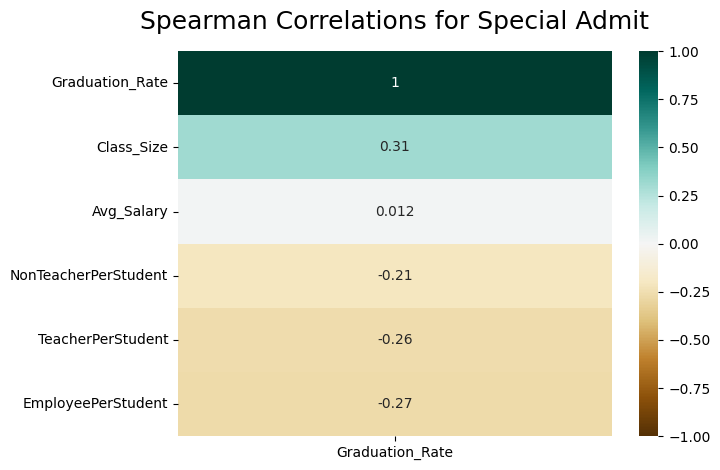

In [209]:
import matplotlib.pyplot as plt
import seaborn as sns

inputs = ['Graduation_Rate','Class_Size', 'EmployeePerStudent', 'TeacherPerStudent', 'NonTeacherPerStudent', 'Avg_Salary']

plt.figure(figsize=(7, 5))
heatmap = sns.heatmap(specialAdmitDF[inputs].corr(method="spearman")[["Graduation_Rate"]].sort_values(by="Graduation_Rate", ascending=False), vmin=-1, vmax=1, annot=True, cmap="BrBG")
heatmap.set_title("Spearman Correlations for Special Admit", fontdict={"fontsize":18}, pad=16)

#### Citywide Admit Schools Spearman Correlation

Text(0.5, 1.0, 'Spearman Correlations for Citywide Admit')

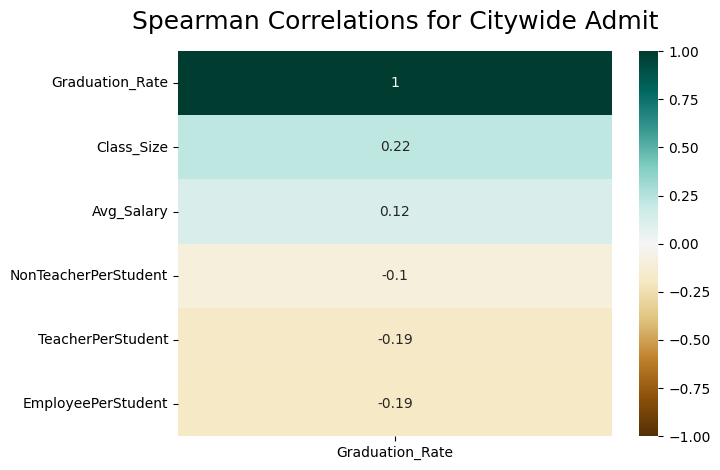

In [210]:
import matplotlib.pyplot as plt
import seaborn as sns

inputs = ['Graduation_Rate','Class_Size', 'EmployeePerStudent', 'TeacherPerStudent', 'NonTeacherPerStudent', 'Avg_Salary']

plt.figure(figsize=(7, 5))
heatmap = sns.heatmap(citywideDF[inputs].corr(method="spearman")[["Graduation_Rate"]].sort_values(by="Graduation_Rate", ascending=False), vmin=-1, vmax=1, annot=True, cmap="BrBG")
heatmap.set_title("Spearman Correlations for Citywide Admit", fontdict={"fontsize":18}, pad=16)

#### Neighborhood Admit Schools Spearman Correlation

Text(0.5, 1.0, 'Spearman Correlations for Neighborhood Admit')

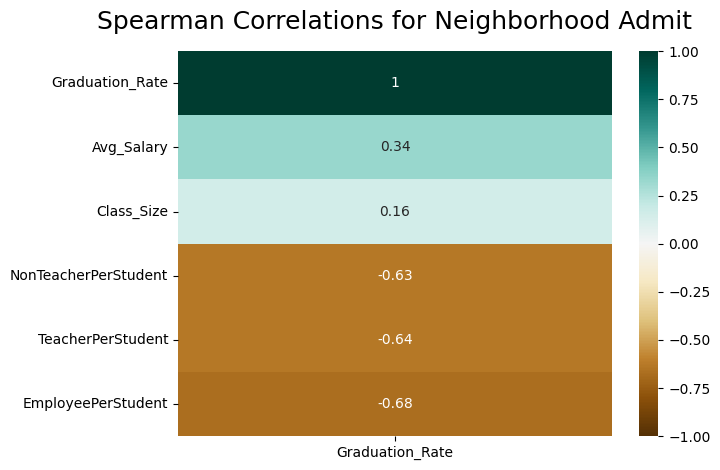

In [211]:
import matplotlib.pyplot as plt
import seaborn as sns

inputs = ['Graduation_Rate','Class_Size', 'EmployeePerStudent', 'TeacherPerStudent', 'NonTeacherPerStudent', 'Avg_Salary']

plt.figure(figsize=(7, 5))
heatmap = sns.heatmap(neighborhoodDF[inputs].corr(method="spearman")[["Graduation_Rate"]].sort_values(by="Graduation_Rate", ascending=False), vmin=-1, vmax=1, annot=True, cmap="BrBG")
heatmap.set_title("Spearman Correlations for Neighborhood Admit", fontdict={"fontsize":18}, pad=16)

### Examine Relationships with Student Group for Neighborhood Admit Schools

Now that a relationship with employment stats and neighborhood admission schools has been established, there might be additional patterns in the Student Group Data once it's narrowed down to Neighborhood only.

Specifically I wanted to look at Student Groups that have clusters of lower graduation rates - Has IEP, EL and Male. I also wanted to compare Economically & Not Economically Disadvantaged because there is an interesting cluster of low graduation for Not Economically Disadvantated students.


<Axes: xlabel='Graduation_Rate', ylabel='Student_Group'>

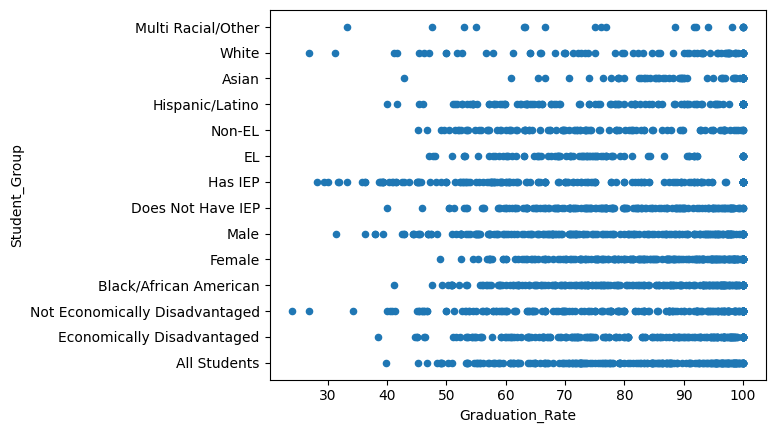

In [212]:
pandasDF.plot.scatter(x='Graduation_Rate', y='Student_Group')

<Axes: xlabel='Graduation_Rate', ylabel='TeacherPerStudent'>

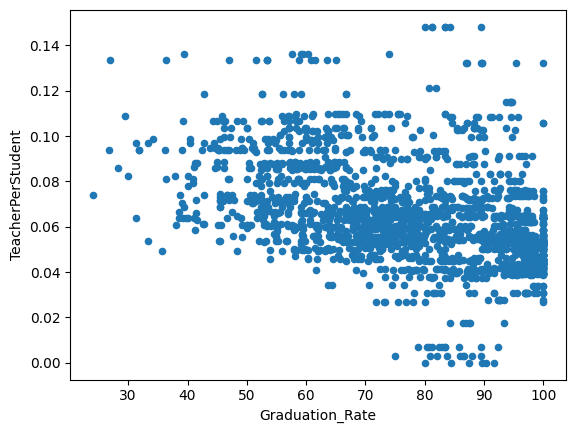

In [213]:
pandasDF.plot.scatter(x='Graduation_Rate', y='TeacherPerStudent')

#### Spearman for Students with IEP

In [214]:
hasIEPDF = pandasDF.loc[(pandasDF['Student_Group'] == 'Has IEP') & (pandasDF['Admission Type'] == 'Neighborhood')]

Text(0.5, 1.0, 'Spearman Correlations for Neighborhood Admit with IEP')

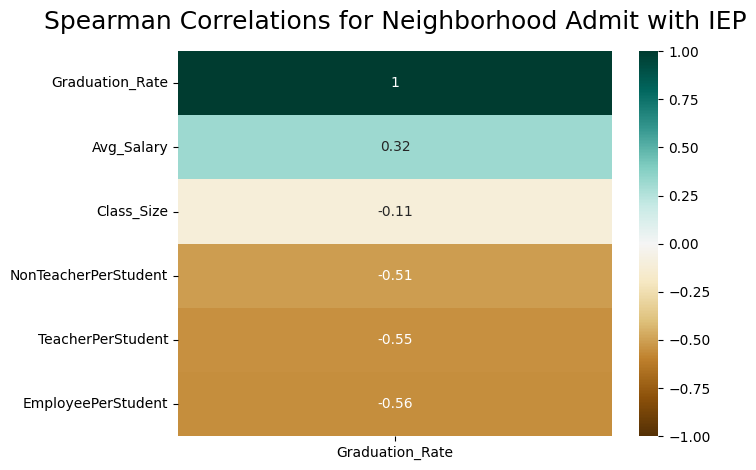

In [215]:
import matplotlib.pyplot as plt
import seaborn as sns

inputs = ['Graduation_Rate','Class_Size', 'EmployeePerStudent', 'TeacherPerStudent', 'NonTeacherPerStudent', 'Avg_Salary']

plt.figure(figsize=(7, 5))
heatmap = sns.heatmap(hasIEPDF[inputs].corr(method="spearman")[["Graduation_Rate"]].sort_values(by="Graduation_Rate", ascending=False), vmin=-1, vmax=1, annot=True, cmap="BrBG")
heatmap.set_title("Spearman Correlations for Neighborhood Admit with IEP", fontdict={"fontsize":18}, pad=16)

#### Spearman for Students Not Economically Disadvantaged

In [216]:
notEDDF = pandasDF.loc[(pandasDF['Student_Group'] == 'Not Economically Disadvantaged') & (pandasDF['Admission Type'] == 'Neighborhood')]

Text(0.5, 1.0, 'Spearman Correlations for Neighborhood Admit not Econ Disadvantaged')

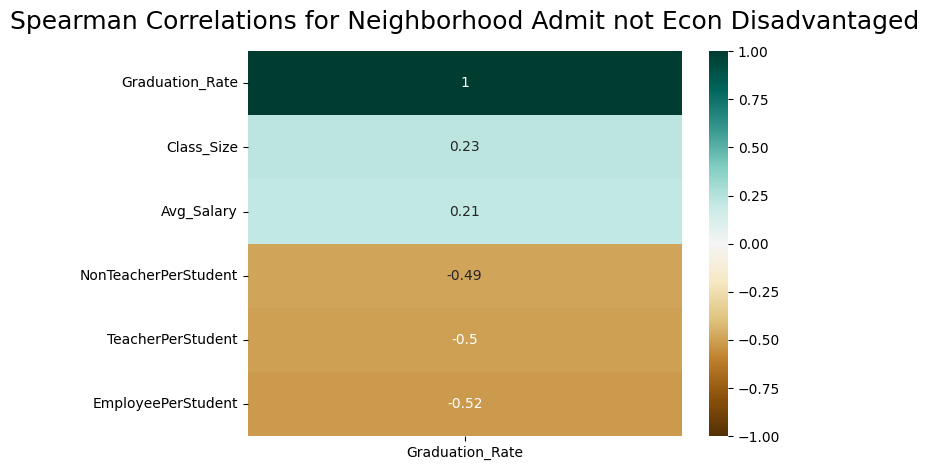

In [217]:
import matplotlib.pyplot as plt
import seaborn as sns

inputs = ['Graduation_Rate','Class_Size', 'EmployeePerStudent', 'TeacherPerStudent', 'NonTeacherPerStudent', 'Avg_Salary']

plt.figure(figsize=(7, 5))
heatmap = sns.heatmap(notEDDF[inputs].corr(method="spearman")[["Graduation_Rate"]].sort_values(by="Graduation_Rate", ascending=False), vmin=-1, vmax=1, annot=True, cmap="BrBG")
heatmap.set_title("Spearman Correlations for Neighborhood Admit not Econ Disadvantaged", fontdict={"fontsize":18}, pad=16)

#### Spearman for English Learners (EL)

In [218]:
elDF = pandasDF.loc[(pandasDF['Student_Group'] == 'EL') & (pandasDF['Admission Type'] == 'Neighborhood')]

Text(0.5, 1.0, 'Spearman Correlations for Neighborhood Admit English Learners (EL)')

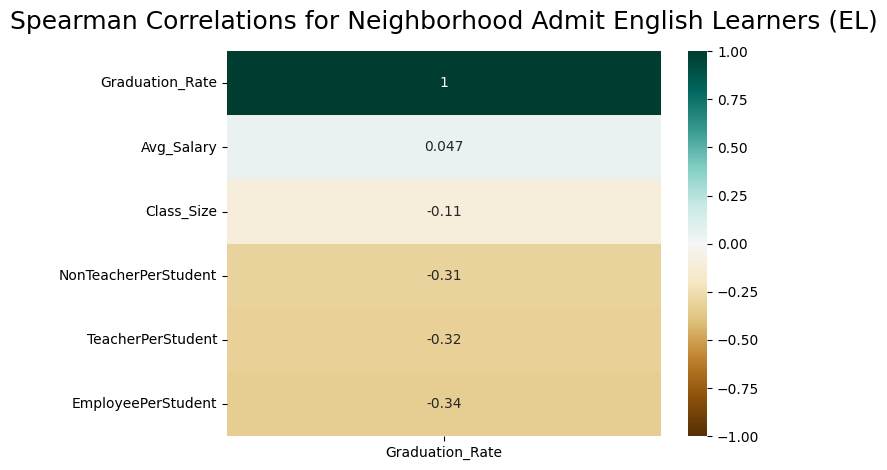

In [219]:
import matplotlib.pyplot as plt
import seaborn as sns

inputs = ['Graduation_Rate','Class_Size', 'EmployeePerStudent', 'TeacherPerStudent', 'NonTeacherPerStudent', 'Avg_Salary']

plt.figure(figsize=(7, 5))
heatmap = sns.heatmap(elDF[inputs].corr(method="spearman")[["Graduation_Rate"]].sort_values(by="Graduation_Rate", ascending=False), vmin=-1, vmax=1, annot=True, cmap="BrBG")
heatmap.set_title("Spearman Correlations for Neighborhood Admit English Learners (EL)", fontdict={"fontsize":18}, pad=16)

#### Spearman for Male Students

In [220]:
maleDF = pandasDF.loc[(pandasDF['Student_Group'] == 'Male') & (pandasDF['Admission Type'] == 'Neighborhood')]

Text(0.5, 1.0, 'Spearman Correlations for Neighborhood Admit Males')

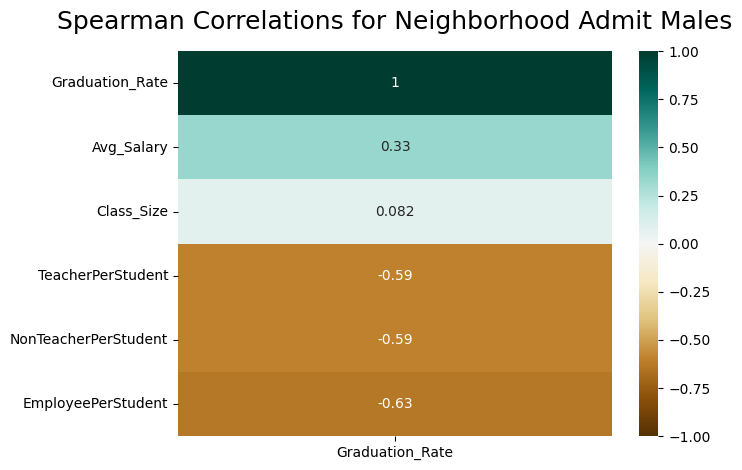

In [221]:
import matplotlib.pyplot as plt
import seaborn as sns

inputs = ['Graduation_Rate','Class_Size', 'EmployeePerStudent', 'TeacherPerStudent', 'NonTeacherPerStudent', 'Avg_Salary']

plt.figure(figsize=(7, 5))
heatmap = sns.heatmap(maleDF[inputs].corr(method="spearman")[["Graduation_Rate"]].sort_values(by="Graduation_Rate", ascending=False), vmin=-1, vmax=1, annot=True, cmap="BrBG")
heatmap.set_title("Spearman Correlations for Neighborhood Admit Males", fontdict={"fontsize":18}, pad=16)

#### Spearman for Economically Disadvantaged

In [222]:
edDF = pandasDF.loc[(pandasDF['Student_Group'] == 'Economically Disadvantaged') & (pandasDF['Admission Type'] == 'Neighborhood')]

Text(0.5, 1.0, 'Spearman Correlations for Neighborhood Economically Disadvantaged')

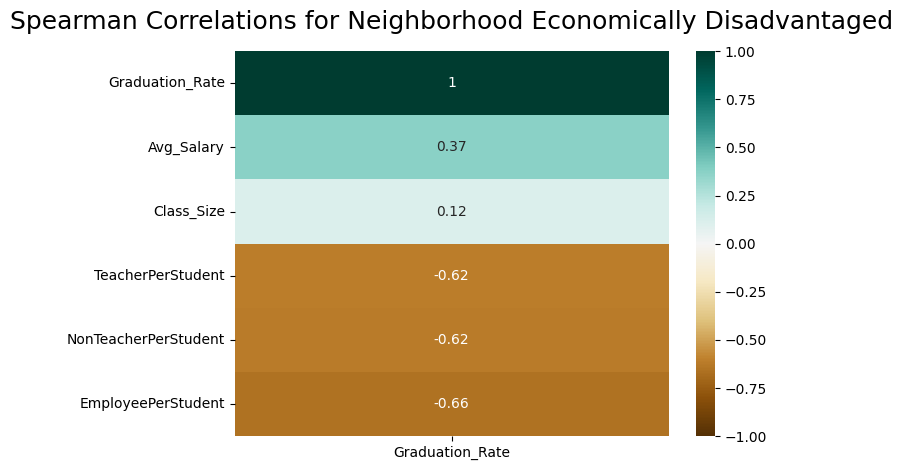

In [223]:
import matplotlib.pyplot as plt
import seaborn as sns

inputs = ['Graduation_Rate','Class_Size', 'EmployeePerStudent', 'TeacherPerStudent', 'NonTeacherPerStudent', 'Avg_Salary']

plt.figure(figsize=(7, 5))
heatmap = sns.heatmap(edDF[inputs].corr(method="spearman")[["Graduation_Rate"]].sort_values(by="Graduation_Rate", ascending=False), vmin=-1, vmax=1, annot=True, cmap="BrBG")
heatmap.set_title("Spearman Correlations for Neighborhood Economically Disadvantaged", fontdict={"fontsize":18}, pad=16)

#### Spearman Results Review
Drilling in by student group there is a pretty interesting result. Employment statistics are strongly correlated with graduation rates for economically disadvantaged students and Males. They have a significant relationship with Not Economically Disadvantaged, but a weak relationship with IEP and English Learners.

Overall, there is a negative relationship between employee per student and graduation rates. I hypothesized that this could be the case, possibly because resources are being sent to low performing schools. There is also a slight positive relationship with class size, so in general we may be seeing that the larger schools are performing better. They have more students, and likely lower employee to student ratios, but in some way their size is beneficial.

There is a somewhat strong positive relationship bewteen average salary and graduation rates as well.

### Linear Regression Model

Now that there is a clearer understanding of the data points and their importance, I will run a linear regression model to get a different view the relationships. I transformed the data with VectorAssembler in Section 3, but I want to now limit it based on what has been learned to Neighborhood Admit, All Student Data.

The Features used will be the Numerical Features - Class Size, EmployeePerStudent, TeacherPerStudent, NonTeacherPerStudent, Avg_Salary. The target is Graduation Rate.

Below the model will be set up, run, then the prectictions evaluated.

#### Run the Linear Regression Model

In [224]:
#Adjust output DF to only include Neighborhood and All Students
output1 = output.where((col("Admission Type") == 'Neighborhood') & (col("Student_Group") == 'All Students'))

In [225]:
finalised_data = output1.select("Features", "Graduation_Rate")

In [226]:
train_data, test_data = finalised_data.randomSplit([0.75, 0.25])

In [227]:
from pyspark.ml.regression import LinearRegression

regressor = LinearRegression(featuresCol = 'Features', labelCol = 'Graduation_Rate')
regressor = regressor.fit(train_data)

#### Evaluate Performance of the Model

In [228]:
pred_results = regressor.evaluate(test_data)
pred_results.predictions.show(truncate = False)

/content/spark-3.2.4-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+---------------------------------------------------------------------------------------+---------------+-----------------+
|Features                                                                               |Graduation_Rate|prediction       |
+---------------------------------------------------------------------------------------+---------------+-----------------+
|[97.0,0.20876288659793815,0.10051546391752578,0.10824742268041238,47854.225]           |67.01          |56.5856973118826 |
|[100.0,0.0575,0.0175,0.04,49311.5]                                                     |87.0           |74.89575879783057|
|[102.0,0.19607843137254902,0.09313725490196079,0.10294117647058823,50042.9125]         |69.61          |58.99231484736353|
|[103.0,0.21359223300970873,0.08495145631067962,0.12864077669902912,45903.15909090909]  |64.08          |58.55335502981026|
|[108.0,0.09490740740740741,0.06018518518518518,0.034722222222222224,56419.80487804878] |75.0           |69.23671395614953|
|[108.0,

In [229]:
# Do prediction on test data
predicted = regressor.transform(test_data)

In [230]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="Graduation_Rate", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predicted)
print("Root Mean Squared Error (RMSE) on test data: {:.3f}".format(rmse))

evaluator_r2 = RegressionEvaluator(labelCol="Graduation_Rate", predictionCol="prediction", metricName="rmse")
r2 = evaluator_r2.evaluate(predicted)
print("R-squared (R2) on test data: {:.3f}".format(r2))

Root Mean Squared Error (RMSE) on test data: 8.519
R-squared (R2) on test data: 8.519


In [231]:
coefficients = regressor.coefficients
intercept = regressor.intercept

print("Coefficients: ", coefficients)
print("Intercept: {:.3f}".format(intercept))

Coefficients:  [-0.0022558337403033833,-24.624263166867614,-174.6761571230852,6.992920937387669,0.0003901243569554556]
Intercept: 60.077


#### Predict the Graduate Rates of Sample Students

First I will get the average for all the features, then create some sample students with above and below average statistics and check their predicted graduation rate.

In [232]:
#Get Averages of columns
avgClassSize = output1.agg({'Class_Size': 'avg'}).show()
avgEmployeePerStudent = output1.agg({'EmployeePerStudent': 'avg'}).show()
avgTeacherPerStudent = output1.agg({'TeacherPerStudent': 'avg'}).show()
avgnonTeachPerStudent = output1.agg({'NonTeacherPerStudent': 'avg'}).show()
avgSalarybyCol = output1.agg({'Avg_Salary': 'avg'}).show()

+------------------+
|   avg(Class_Size)|
+------------------+
|220.66304347826087|
+------------------+

+-----------------------+
|avg(EmployeePerStudent)|
+-----------------------+
|    0.14374535217031545|
+-----------------------+

+----------------------+
|avg(TeacherPerStudent)|
+----------------------+
|   0.07347380648901465|
+----------------------+

+-------------------------+
|avg(NonTeacherPerStudent)|
+-------------------------+
|      0.07027154568130077|
+-------------------------+

+------------------+
|   avg(Avg_Salary)|
+------------------+
|52950.564577292105|
+------------------+



In [233]:
from pyspark.ml.linalg import Vectors
# Create vectors for prediction based on given data
studentA = Vectors.dense([250,0.25,0.14,0.14,50000])
studentB = Vectors.dense([250,0.25,0.14,0.14,70000])

In [234]:
# Do prediction on test data for studentA
A_predicted = regressor.predict(studentA)
print("Probability of Student A Graduation")
print(A_predicted)

Probability of Student A Graduation
49.38727654308771


In [235]:
# Do prediction on test data for studentB
B_predicted = regressor.predict(studentB)
print("Probability of Student B Graduation")
print(B_predicted)

Probability of Student B Graduation
57.18976368219682
